<a href="https://colab.research.google.com/github/muskaanramchandani/Tutorial-LTN/blob/main/CODIGO_TUTORIAL_LTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classificação de Gatos e Cachorros com Logic Tensor Networks (LTN)
Implementação Profissional usando Framework Neuro-Simbólico
Seção 1: Setup e Imports
Imports obrigatórios e configuração do ambiente para LTN

In [ ]:
# Install all essential libraries at once
!pip install -q torch torchvision torchaudio LTNtorch numpy matplotlib scikit-learn kagglehub pillow

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import ltn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION CONSTANTS
# ============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ltn.device = DEVICE

# Dataset configuration
DATASET_SAMPLE_SIZE = 100  # Images per class
IMAGE_SIZE = 224
RESNET_FEATURE_DIM = 512
PCA_COMPONENTS = 64

# Model configuration
SYNTHETIC_DATA_SIZE = 200
SYNTHETIC_RANDOM_STATE = 42

# Training configuration
KAGGLE_EPOCHS = 500
SYNTHETIC_EPOCHS = 1000
VERBOSE_INTERVAL = 50

# Visualization
PLOT_GRID_SIZE = 100

print(f"🖥️  Device: {DEVICE}")
print(f"✓ Libraries loaded and ready")

🖥️  Device: cpu
✓ Libraries loaded and ready


In [32]:
def verify_dependencies() -> bool:
    """
    Verify all required dependencies are installed.

    Returns:
        True if all dependencies are available, False otherwise
    """
    print("🔍 Verifying dependencies...\n")

    dependencies = [
        ("torch", lambda: torch.__version__),
        ("ltn", lambda: "installed"),
        ("numpy", lambda: np.__version__),
        ("matplotlib", lambda: __import__('matplotlib').__version__),
        ("sklearn", lambda: __import__('sklearn').__version__),
        ("PIL", lambda: __import__('PIL').__version__),
    ]

    all_ok = True
    for name, version_fn in dependencies:
        try:
            version = version_fn()
            print(f"✓ {name:15} {version}")
        except ImportError:
            print(f"✗ {name:15} NOT installed")
            all_ok = False

    if all_ok:
        print("\n✅ Dependencies OK!")
    else:
        print("\n❌ Required dependencies not found.")
    return all_ok

verify_dependencies()

🔍 Verifying dependencies...

✓ torch           2.8.0+cu126
✓ ltn             installed
✓ numpy           2.0.2
✓ matplotlib      3.10.0
✓ sklearn         1.6.1
✓ PIL             11.3.0

✅ Dependencies OK!


True

Seção 1b: Download do Dataset Kaggle

In [ ]:
import subprocess
import sys
import os
import glob
from PIL import Image
import kagglehub

def ensure_package(package_name: str, import_name: str = None) -> bool:
    """
    Ensure a package is installed, installing if necessary.

    Args:
        package_name: Name of the package to install (pip name)
        import_name: Name to use for import (if different from package_name)

    Returns:
        True if package is available
    """
    import_name = import_name or package_name
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
        return True

# Ensure packages are available
ensure_package("kagglehub")

print("✓ kagglehub available for dataset download")

✓ kagglehub available for dataset download


In [ ]:
def download_dataset(dataset_name: str = "shaunthesheep/microsoft-catsvsdogs-dataset") -> str:
    """
    Download dataset from Kaggle using kagglehub.

    Args:
        dataset_name: Name of the dataset on Kaggle

    Returns:
        Path to downloaded dataset
    """
    print(f"\n📥 Downloading dataset '{dataset_name}'...")
    print("This may take a few minutes on first run...\n")

    dataset_path = kagglehub.dataset_download(dataset_name)
    print(f"✓ Dataset downloaded successfully!")
    print(f"📂 Path: {dataset_path}")

    return dataset_path

def explore_dataset_structure(dataset_path: str, max_depth: int = 2, files_per_dir: int = 3):
    """
    Display the structure of downloaded dataset.

    Args:
        dataset_path: Path to dataset
        max_depth: Maximum depth to traverse
        files_per_dir: Number of files to show per directory
    """
    print(f"\n📁 Dataset structure:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')

        subindent = ' ' * 2 * (level + 1)
        for file in files[:files_per_dir]:
            print(f'{subindent}{file}')
        if len(files) > files_per_dir:
            print(f'{subindent}... and {len(files) - files_per_dir} more files')

        if level >= max_depth:
            break

# Download and explore dataset
dataset_path = download_dataset()
explore_dataset_structure(dataset_path)


📥 Downloading dataset 'shaunthesheep/microsoft-catsvsdogs-dataset'...
This may take a few minutes on first run...

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
✓ Dataset downloaded successfully!
📂 Path: /kaggle/input/microsoft-catsvsdogs-dataset

📁 Dataset structure:
microsoft-catsvsdogs-dataset/
  readme[1].txt
  MSR-LA - 3467.docx
  PetImages/
    Dog/
      7981.jpg
      6234.jpg
      1269.jpg
      ... and 12498 more files


Seção 1c: Processamento de Imagens e Extração de Features
Carregando imagens e extraindo features para classificação com LTN

In [33]:
def load_pretrained_feature_extractor(device: torch.device) -> Tuple[nn.Module, Compose]:
    """
    Load ResNet18 pretrained model for feature extraction.

    Args:
        device: Device to load model on

    Returns:
        Tuple of (model, transform_pipeline)
    """
    print("\n🧠 Loading ResNet18 pretrained model...")

    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.eval()

    # Remove classification layer to get features only
    model = nn.Sequential(*list(model.children())[:-1])
    model.to(device)

    # Image transformation pipeline
    transform = Compose([
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
    ])

    print("✓ ResNet18 loaded and ready for feature extraction")
    return model, transform

def extract_image_features(image_path: str, model: nn.Module,
                          transform: Compose, device: torch.device) -> Optional[torch.Tensor]:
    """
    Extract features from a single image.

    Args:
        image_path: Path to image file
        model: Feature extraction model
        transform: Image transformation pipeline
        device: Device to process on

    Returns:
        Feature tensor or None if error occurs
    """
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model(image)

        return features.flatten().cpu()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Load feature extractor
feature_model, image_transform = load_pretrained_feature_extractor(DEVICE)


🧠 Loading ResNet18 pretrained model...
✓ ResNet18 loaded and ready for feature extraction


In [34]:
def extract_features_batch(image_dir: str, model: nn.Module, transform: Compose,
                          device: torch.device, max_samples: int = DATASET_SAMPLE_SIZE,
                          progress_interval: int = 20) -> Tuple[torch.Tensor, int]:
    """
    Extract features from all images in a directory.

    Args:
        image_dir: Directory containing images
        model: Feature extraction model
        transform: Image transformation pipeline
        device: Device to process on
        max_samples: Maximum number of images to process
        progress_interval: Print progress every N images

    Returns:
        Tuple of (features_tensor, num_successfully_processed)
    """
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))[:max_samples]
    features_list = []

    for i, img_path in enumerate(image_paths):
        if i % progress_interval == 0:
            print(f"   Processed {i}/{len(image_paths)}...")

        features = extract_image_features(img_path, model, transform, device)
        if features is not None:
            features_list.append(features)

    features_tensor = torch.stack(features_list).to(device) if features_list else None
    return features_tensor, len(features_list)

# Load image paths
print("\n📊 Loading and processing images from dataset...")
cats_dir = os.path.join(dataset_path, "PetImages", "Cat")
dogs_dir = os.path.join(dataset_path, "PetImages", "Dog")

# Extract features from both classes
print("\n🔄 Extracting features from cats...")
cat_features_tensor, n_cats = extract_features_batch(cats_dir, feature_model, image_transform, DEVICE)
print(f"✓ {n_cats} cat features extracted successfully")

print("\n🔄 Extracting features from dogs...")
dog_features_tensor, n_dogs = extract_features_batch(dogs_dir, feature_model, image_transform, DEVICE)
print(f"✓ {n_dogs} dog features extracted successfully")

print(f"\n📈 Data dimensions:")
print(f"   • Cats: {cat_features_tensor.shape}")
print(f"   • Dogs: {dog_features_tensor.shape}")


📊 Loading and processing images from dataset...

🔄 Extracting features from cats...
   Processed 0/100...
   Processed 20/100...
   Processed 40/100...
   Processed 60/100...
   Processed 80/100...
✓ 100 cat features extracted successfully

🔄 Extracting features from dogs...
   Processed 0/100...
   Processed 20/100...
   Processed 40/100...
   Processed 60/100...
   Processed 80/100...
✓ 100 dog features extracted successfully

📈 Data dimensions:
   • Cats: torch.Size([100, 512])
   • Dogs: torch.Size([100, 512])


Seção 1d: Normalização de Features
Normalizando as features extraídas para o intervalo [0, 1]

In [ ]:
def normalize_and_reduce_features(cat_features: torch.Tensor, dog_features: torch.Tensor,
                                  device: torch.device, n_components: int = PCA_COMPONENTS) -> Tuple[torch.Tensor, torch.Tensor, PCA]:
    """
    Normalize features to [0,1] and reduce dimensionality with PCA.

    Args:
        cat_features: Tensor of cat features
        dog_features: Tensor of dog features
        device: Device to process on
        n_components: Number of PCA components

    Returns:
        Tuple of (normalized_cat_features, normalized_dog_features, pca_model)
    """
    print("\n🔧 Normalizing features to [0, 1]...")

    # Concatenate and find min/max
    all_features = torch.cat([cat_features, dog_features], dim=0)
    feature_min = all_features.min(dim=0)[0]
    feature_max = all_features.max(dim=0)[0]

    # Normalize
    cat_norm = (cat_features - feature_min) / (feature_max - feature_min + 1e-8)
    dog_norm = (dog_features - feature_min) / (feature_max - feature_min + 1e-8)
    cat_norm = torch.clamp(cat_norm, 0, 1)
    dog_norm = torch.clamp(dog_norm, 0, 1)

    print(f"✓ Features normalized")
    print(f"   • Min: {cat_norm.min():.4f}, Max: {cat_norm.max():.4f}")
    print(f"   • Original dimension: {cat_norm.shape[1]}")

    # Apply PCA
    print(f"\n📉 Reducing dimensionality with PCA (→ {n_components} components)...")
    all_features_cpu = torch.cat([cat_norm, dog_norm], dim=0).cpu().numpy()

    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(all_features_cpu)

    # Normalize after PCA
    features_pca_min = features_pca.min(axis=0)
    features_pca_max = features_pca.max(axis=0)
    features_pca_norm = (features_pca - features_pca_min) / (features_pca_max - features_pca_min + 1e-8)
    features_pca_norm = np.clip(features_pca_norm, 0, 1)

    # Split back into classes
    n_cats = cat_norm.shape[0]
    cat_final = torch.tensor(features_pca_norm[:n_cats], dtype=torch.float32).to(device)
    dog_final = torch.tensor(features_pca_norm[n_cats:], dtype=torch.float32).to(device)

    print(f"✓ PCA applied successfully")
    print(f"   • Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"   • Final dimension: {cat_final.shape[1]}")
    print(f"\n📊 Final data shapes:")
    print(f"   • Cats: {cat_final.shape}")
    print(f"   • Dogs: {dog_final.shape}")

    return cat_final, dog_final, pca

# Normalize and reduce features
cat_features_final, dog_features_final, pca = normalize_and_reduce_features(
    cat_features_tensor, dog_features_tensor, DEVICE
)


🔧 Normalizing features to [0, 1]...
✓ Features normalized
   • Min: 0.0000, Max: 1.0000
   • Original dimension: 512

📉 Reducing dimensionality with PCA (→ 64 components)...
✓ PCA applied successfully
   • Variance explained: 82.99%
   • Final dimension: 64

📊 Final data shapes:
   • Cats: torch.Size([100, 64])
   • Dogs: torch.Size([100, 64])


Seção 2: Classe MLPPredicate
Rede neural que será usada como predicado lógico no framework LTN

In [ ]:
class MLPPredicate(nn.Module):
    """
    Perceptron Multicamadas (MLP) para uso como predicado LTN.

    Esta rede neural serve como predicado lógico, mapeando inputs
    para valores de verdade no intervalo [0, 1].
    """

    def __init__(self, input_size: int, hidden_size: int, output_size: int = 1):
        """
        Args:
            input_size: Dimensão da entrada
            hidden_size: Número de neurônios na camada oculta
            output_size: Dimensão da saída (1 para predicado unário)
        """
        super(MLPPredicate, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularização
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, output_size),
            nn.Sigmoid()  # Saída em [0, 1] para lógica fuzzy
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass da rede"""
        return self.network(x)

In [ ]:
def extract_value(ltn_obj) -> float:
    """
    Extrai o valor numérico de um LTNObject ou tensor.

    Esta função resolve o erro 'LTNObject has no attribute item'
    ao converter LTNObjects para valores float.

    Args:
        ltn_obj: LTNObject, tensor ou valor numérico

    Returns:
        Valor float extraído
    """
    if hasattr(ltn_obj, 'value'):
        # É um LTNObject, extrair o tensor interno
        tensor = ltn_obj.value
        return tensor.item() if torch.is_tensor(tensor) else float(tensor)
    elif torch.is_tensor(ltn_obj):
        # É um tensor direto
        return ltn_obj.item()
    else:
        # Já é um valor numérico
        return float(ltn_obj)

Seção 3: Classificador Binário com LTN
Classe que encapsula toda a lógica de treinamento e inferência usando LTN

In [35]:
class BinaryClassifierLTN:
    """
    Binary classifier using Logic Tensor Networks (LTN).

    Combines neural networks with neuro-symbolic learning through
    fuzzy logic axioms and logical quantifiers.
    """

    def __init__(
        self,
        input_dim: int = 2,
        hidden_dim: int = 32,
        learning_rate: float = 0.001,
        p_value: int = 2,
        device: torch.device = None
    ):
        """
        Initialize LTN classifier.

        Args:
            input_dim: Input feature dimension
            hidden_dim: Hidden layer size
            learning_rate: Adam optimizer learning rate
            p_value: Parameter for p-mean aggregation
            device: torch device (defaults to GPU if available)
        """
        self.device = device or DEVICE
        ltn.device = self.device

        # Model architecture
        self.model = MLPPredicate(input_dim, hidden_dim).to(self.device)
        self.A = ltn.Predicate(self.model)

        # Logical operators (fuzzy logic)
        self.Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
        self.And = ltn.Connective(ltn.fuzzy_ops.AndProd())
        self.Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
        self.Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())

        # Quantifiers with p-mean aggregation
        self.Forall = ltn.Quantifier(
            ltn.fuzzy_ops.AggregPMeanError(p=p_value),
            quantifier="f"
        )
        self.Exists = ltn.Quantifier(
            ltn.fuzzy_ops.AggregPMean(p=p_value),
            quantifier="e"
        )

        self.sat_agg = ltn.fuzzy_ops.SatAgg()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Training history
        self.history: Dict[str, List[float]] = {
            'loss': [],
            'satisfaction': [],
            'axiom_A_sat': [],
            'axiom_B_sat': []
        }

        print(f"🖥️  Using device: {self.device}")

    def define_knowledge_base(self, x_A: ltn.Variable,
                             x_B: ltn.Variable) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Define logical knowledge base with axioms.

        Axioms:
        1. ∀x_A: A(x_A)  - All positive examples must be class A
        2. ∀x_B: ¬A(x_B) - All negative examples must NOT be class A

        Args:
            x_A: LTN Variable with positive examples
            x_B: LTN Variable with negative examples

        Returns:
            (total_satisfaction, axiom_A_satisfaction, axiom_B_satisfaction)
        """
        axiom_A = self.Forall(x_A, self.A(x_A))
        axiom_B = self.Forall(x_B, self.Not(self.A(x_B)))
        sat = self.sat_agg(axiom_A, axiom_B)

        return sat, axiom_A, axiom_B

    def train_step(self, data_pos: torch.Tensor,
                  data_neg: torch.Tensor) -> Tuple[float, float, float, float]:
        """
        Execute one training step.

        Args:
            data_pos: Positive class batch
            data_neg: Negative class batch

        Returns:
            (loss, satisfaction, axiom_A_sat, axiom_B_sat)
        """
        self.optimizer.zero_grad()

        x_A = ltn.Variable("x_A", data_pos)
        x_B = ltn.Variable("x_B", data_neg)

        sat, axiom_A, axiom_B = self.define_knowledge_base(x_A, x_B)
        loss = 1.0 - sat

        loss.backward()
        self.optimizer.step()

        return (
            extract_value(loss),
            extract_value(sat),
            extract_value(axiom_A),
            extract_value(axiom_B)
        )

    def fit(self, data_pos: torch.Tensor, data_neg: torch.Tensor,
            epochs: int = 1000, verbose: int = 100):
        """
        Train the LTN model.

        Args:
            data_pos: Positive class data
            data_neg: Negative class data
            epochs: Number of training epochs
            verbose: Print frequency (0 = silent)
        """
        print(f"\n🚀 Starting training for {epochs} epochs...\n")

        for epoch in range(epochs):
            loss, sat, sat_A, sat_B = self.train_step(data_pos, data_neg)

            self.history['loss'].append(loss)
            self.history['satisfaction'].append(sat)
            self.history['axiom_A_sat'].append(sat_A)
            self.history['axiom_B_sat'].append(sat_B)

            if verbose > 0 and epoch % verbose == 0:
                print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Sat: {sat:.4f} | "
                      f"Sat(A): {sat_A:.4f} | Sat(¬B): {sat_B:.4f}")

        print(f"\n✅ Training complete!")
        print(f"📊 Final satisfaction: {self.history['satisfaction'][-1]:.4f}")

    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """
        Make predictions on new data.

        Args:
            x: Input tensor

        Returns:
            Truth values in [0, 1]
        """
        self.model.eval()
        x = x.to(self.device)
        return self.model(x)

    def plot_training_history(self):
        """Visualize training metrics."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        ax1 = axes[0]
        ax1.plot(self.history['loss'], label='Loss', color='red', linewidth=2)
        ax1.plot(self.history['satisfaction'], label='KB Satisfaction',
                color='green', linewidth=2)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)
        ax1.set_title('Training Evolution', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)

        ax2 = axes[1]
        ax2.plot(self.history['axiom_A_sat'], label='Sat(∀x_A: A(x_A))',
                color='blue', linewidth=2)
        ax2.plot(self.history['axiom_B_sat'], label='Sat(∀x_B: ¬A(x_B))',
                color='orange', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Satisfaction', fontsize=12)
        ax2.set_title('Axiom Satisfaction', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_decision_boundary(self, data_pos: torch.Tensor, data_neg: torch.Tensor,
                              grid_size: int = PLOT_GRID_SIZE):
        """
        Visualize learned decision boundary.

        Args:
            data_pos: Positive class data
            data_neg: Negative class data
            grid_size: Resolution of decision grid
        """
        x_min, x_max = -0.1, 1.1
        y_min, y_max = -0.1, 1.1

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_size),
            np.linspace(y_min, y_max, grid_size)
        )

        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_tensor = torch.FloatTensor(grid_points).to(self.device)

        truth_values = self.predict(grid_tensor).cpu().numpy()
        zz = truth_values.reshape(xx.shape)

        fig, ax = plt.subplots(figsize=(10, 8))

        contour = ax.contourf(xx, yy, zz, levels=20, cmap='RdYlGn', alpha=0.8)
        ax.contour(xx, yy, zz, levels=[0.5], colors='black', linewidths=2, linestyles='--')

        data_pos_np = data_pos.cpu().numpy()
        data_neg_np = data_neg.cpu().numpy()

        ax.scatter(data_pos_np[:, 0], data_pos_np[:, 1],
                  c='darkgreen', s=100, edgecolors='black', linewidths=1.5,
                  label='Cats (Positive)', marker='o', alpha=0.9)
        ax.scatter(data_neg_np[:, 0], data_neg_np[:, 1],
                  c='darkred', s=100, edgecolors='black', linewidths=1.5,
                  label='Dogs (Negative)', marker='s', alpha=0.9)

        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label('Truth Value A(x) - Cat(x)', fontsize=12, rotation=270, labelpad=20)

        ax.set_xlabel('Feature 1', fontsize=13, fontweight='bold')
        ax.set_ylabel('Feature 2', fontsize=13, fontweight='bold')
        ax.set_title('Decision Boundary: Cats vs Dogs Classification',
                    fontsize=14, fontweight='bold', pad=20)
        ax.legend(fontsize=11, loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        plt.tight_layout()
        plt.show()

Seção 4: Funções Auxiliares
Funções para geração de dados sintéticos e visualização

In [36]:
def generate_synthetic_data(n_pos: int = SYNTHETIC_DATA_SIZE,
                           n_neg: int = SYNTHETIC_DATA_SIZE,
                           random_state: int = SYNTHETIC_RANDOM_STATE) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate synthetic 2D data for binary classification.

    Positive class (Cats): Center cluster
    Negative class (Dogs): Border points

    Args:
        n_pos: Number of positive examples
        n_neg: Number of negative examples
        random_state: Random seed for reproducibility

    Returns:
        Tuple of (positive_data, negative_data)
    """
    torch.manual_seed(random_state)
    np.random.seed(random_state)

    # Positive class: Center cluster
    pos_data = torch.rand((n_pos, 2)) * 0.4 + 0.3

    # Negative class: Border regions
    n_neg_half = n_neg // 2
    neg_1 = torch.rand((n_neg_half, 2)) * 0.35
    neg_2 = torch.rand((n_neg - n_neg_half, 2)) * 0.35 + 0.65
    neg_data = torch.cat((neg_1, neg_2), dim=0)

    return pos_data, neg_data

def plot_scatter_data(data_pos: torch.Tensor, data_neg: torch.Tensor,
                     title: str = "Training Data", use_2d: bool = True):
    """
    Plot scatter plot of classification data.

    Args:
        data_pos: Positive class data
        data_neg: Negative class data
        title: Plot title
        use_2d: Whether data is 2D (for synthetic) or needs dimensionality reduction
    """
    if not use_2d:
        # For high-dimensional data, use tSNE
        print("⏳ Applying tSNE for 2D visualization...")
        all_data = torch.cat([data_pos, data_neg], dim=0).cpu().numpy()
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        data_2d = tsne.fit_transform(all_data)
        data_pos_plot = data_2d[:data_pos.shape[0]]
        data_neg_plot = data_2d[data_pos.shape[0]:]
        print("✓ tSNE visualization complete")
    else:
        data_pos_plot = data_pos.cpu().numpy() if torch.is_tensor(data_pos) else data_pos
        data_neg_plot = data_neg.cpu().numpy() if torch.is_tensor(data_neg) else data_neg

    plt.figure(figsize=(10, 10))

    plt.scatter(data_pos_plot[:, 0], data_pos_plot[:, 1],
               c='orange', s=100, alpha=0.8, edgecolors='black', linewidths=1.5,
               label=f'🐱 Cats (Positive) - {len(data_pos)} samples', marker='o')
    plt.scatter(data_neg_plot[:, 0], data_neg_plot[:, 1],
               c='brown', s=100, alpha=0.8, edgecolors='black', linewidths=1.5,
               label=f'🐕 Dogs (Negative) - {len(data_neg)} samples', marker='^')

    xlabel = 'tSNE Dimension 1' if not use_2d else 'Feature 1'
    ylabel = 'tSNE Dimension 2' if not use_2d else 'Feature 2'

    plt.xlabel(xlabel, fontsize=13, fontweight='bold')
    plt.ylabel(ylabel, fontsize=13, fontweight='bold')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3)

    if use_2d:
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)

    plt.tight_layout()
    plt.show()

# Generate synthetic data
data_pos, data_neg = generate_synthetic_data()
print(f"\n📊 Synthetic data generated:")
print(f"   ✓ Cats (Positive): {data_pos.shape[0]} samples")
print(f"   ✓ Dogs (Negative): {data_neg.shape[0]} samples")
print(f"   ✓ Dimensionality: {data_pos.shape[1]} features")


📊 Synthetic data generated:
   ✓ Cats (Positive): 200 samples
   ✓ Dogs (Negative): 200 samples
   ✓ Dimensionality: 2 features


Seção 4b: Função para Dados Reais do Kaggle
Adaptação da função de geração de dados para usar o dataset real

Seção 5: Execução Principal - Pipeline Completo
Classificação de Gatos vs Cachorros com LTN

BINARY CLASSIFICATION WITH LOGIC TENSOR NETWORKS (LTN)
🐱 Cats vs 🐕 Dogs - Synthetic Data

📈 Step 1: Visualizing initial synthetic data distribution...


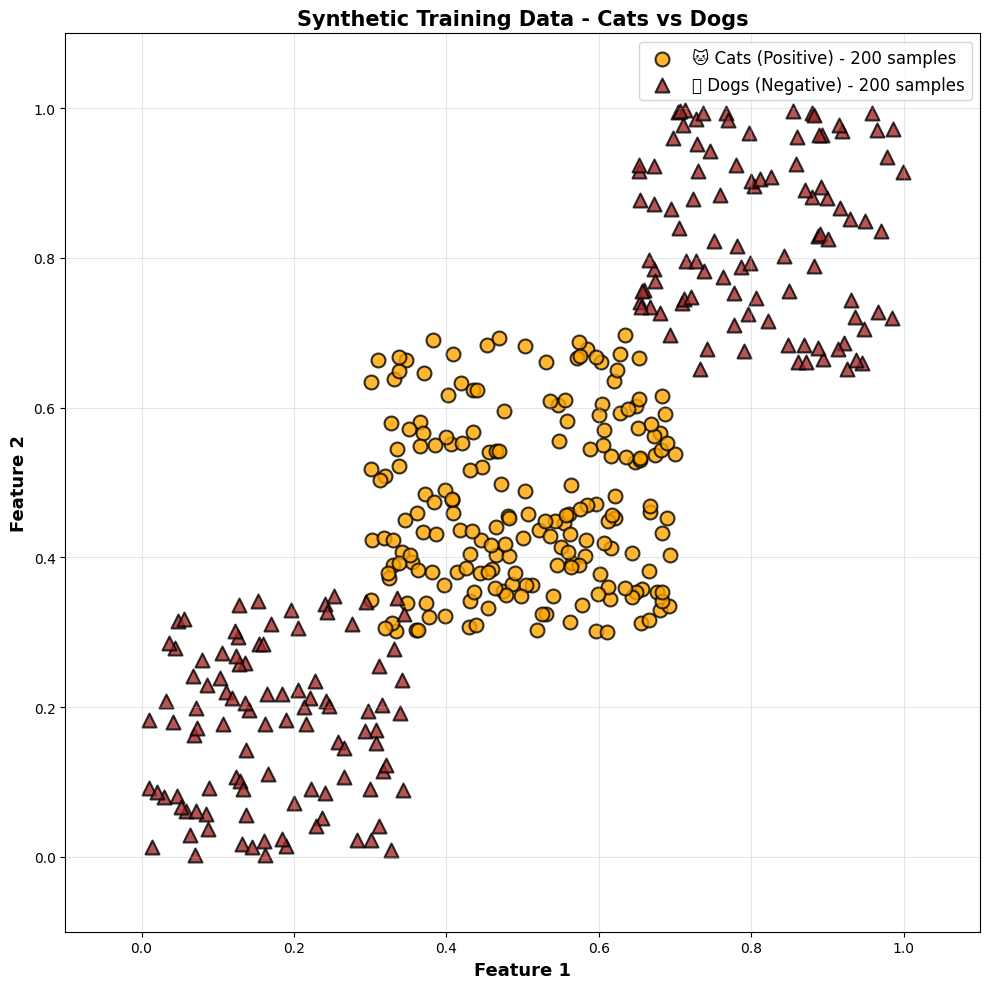

In [ ]:
print("=" * 80)
print("BINARY CLASSIFICATION WITH LOGIC TENSOR NETWORKS (LTN)")
print("🐱 Cats vs 🐕 Dogs - Synthetic Data")
print("=" * 80)

print("\n📈 Step 1: Visualizing initial synthetic data distribution...")
plot_scatter_data(data_pos, data_neg, "Synthetic Training Data - Cats vs Dogs")

Seção 5b: Execução com Dados Reais do Kaggle
Pipeline Completo usando Dataset Real de Gatos vs Cachorros


CLASSIFICATION WITH REAL KAGGLE DATA
Dataset: Microsoft Cats vs Dogs

📊 Step 1: Real dataset already extracted and processed
   ✓ Cats (Positive): 100 samples with 64 features
   ✓ Dogs (Negative): 100 samples with 64 features

📈 Step 2: Visualizing real data distribution with tSNE...
⏳ Applying tSNE for 2D visualization...
✓ tSNE visualization complete


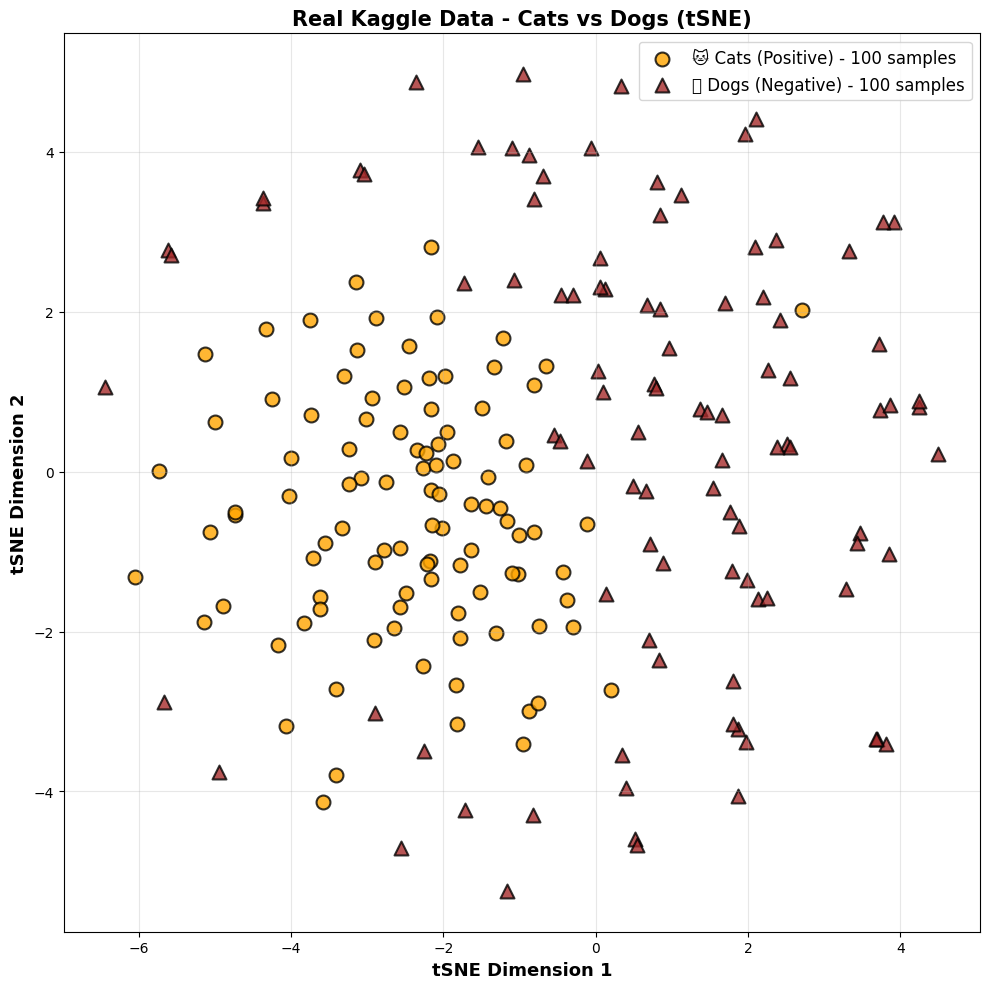

In [ ]:
print("\n" + "=" * 80)
print("CLASSIFICATION WITH REAL KAGGLE DATA")
print("Dataset: Microsoft Cats vs Dogs")
print("=" * 80)

print(f"\n📊 Step 1: Real dataset already extracted and processed")
print(f"   ✓ Cats (Positive): {cat_features_final.shape[0]} samples with {cat_features_final.shape[1]} features")
print(f"   ✓ Dogs (Negative): {dog_features_final.shape[0]} samples with {dog_features_final.shape[1]} features")

print(f"\n📈 Step 2: Visualizing real data distribution with tSNE...")
plot_scatter_data(cat_features_final, dog_features_final,
                 "Real Kaggle Data - Cats vs Dogs (tSNE)", use_2d=False)

In [ ]:
print("\n🏗️  Step 3: Building LTN classifier for real Kaggle data...")
print(f"   Configuration:")
print(f"   - Input Dimension: {cat_features_final.shape[1]} (ResNet18 → PCA)")
print(f"   - Hidden Dimension: 128")
print(f"   - Learning Rate: 0.001")
print(f"   - P-value: 2")

classifier_real = BinaryClassifierLTN(
    input_dim=cat_features_final.shape[1],
    hidden_dim=128,
    learning_rate=0.001,
    p_value=2,
    device=DEVICE
)


🏗️  Step 3: Building LTN classifier for real Kaggle data...
   Configuration:
   - Input Dimension: 64 (ResNet18 → PCA)
   - Hidden Dimension: 128
   - Learning Rate: 0.001
   - P-value: 2
🖥️  Using device: cpu


In [ ]:
print("\n🎯 Step 4: Training with logical axioms (real Kaggle data)...")
print("   Knowledge Base Axioms:")
print("   - Axiom 1: ∀x_cat: Cat(x_cat) [All cat features → Cat class]")
print("   - Axiom 2: ∀x_dog: ¬Cat(x_dog) [All dog features → NOT Cat class]\n")

classifier_real.fit(
    data_pos=cat_features_final,
    data_neg=dog_features_final,
    epochs=KAGGLE_EPOCHS,
    verbose=VERBOSE_INTERVAL
)


🎯 Step 4: Training with logical axioms (real Kaggle data)...
   Knowledge Base Axioms:
   - Axiom 1: ∀x_cat: Cat(x_cat) [All cat features → Cat class]
   - Axiom 2: ∀x_dog: ¬Cat(x_dog) [All dog features → NOT Cat class]


🚀 Starting training for 500 epochs...

Epoch    0 | Loss: 0.5024 | Sat: 0.4976 | Sat(A): 0.4590 | Sat(¬B): 0.5394
Epoch   50 | Loss: 0.3709 | Sat: 0.6291 | Sat(A): 0.6265 | Sat(¬B): 0.6318
Epoch  100 | Loss: 0.1187 | Sat: 0.8813 | Sat(A): 0.9320 | Sat(¬B): 0.8467
Epoch  150 | Loss: 0.0227 | Sat: 0.9773 | Sat(A): 0.9756 | Sat(¬B): 0.9793
Epoch  200 | Loss: 0.0184 | Sat: 0.9816 | Sat(A): 0.9936 | Sat(¬B): 0.9750
Epoch  250 | Loss: 0.0184 | Sat: 0.9816 | Sat(A): 0.9973 | Sat(¬B): 0.9742
Epoch  300 | Loss: 0.0102 | Sat: 0.9898 | Sat(A): 0.9866 | Sat(¬B): 0.9950
Epoch  350 | Loss: 0.0026 | Sat: 0.9974 | Sat(A): 0.9968 | Sat(¬B): 0.9987
Epoch  400 | Loss: 0.0013 | Sat: 0.9987 | Sat(A): 0.9991 | Sat(¬B): 0.9985
Epoch  450 | Loss: 0.0042 | Sat: 0.9958 | Sat(A): 0.9943 | Sat(


📊 Step 5: Training history visualization...


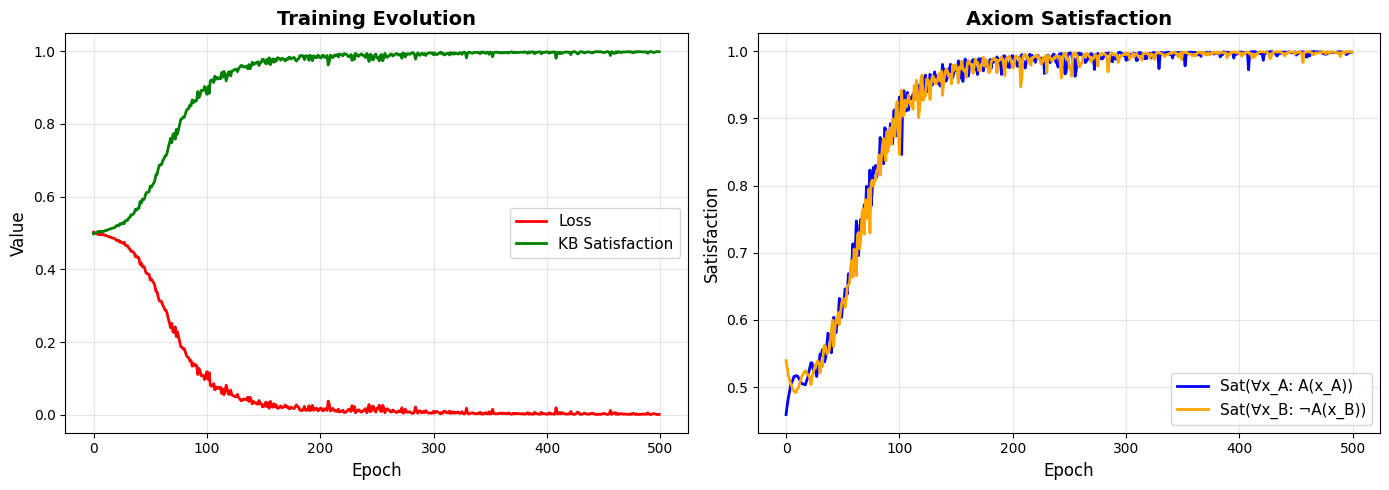

In [ ]:
print("\n📊 Step 5: Training history visualization...")
classifier_real.plot_training_history()

In [37]:
def evaluate_model(classifier: BinaryClassifierLTN, data_pos: torch.Tensor,
                   data_neg: torch.Tensor, model_name: str = "Model"):
    """
    Evaluate and print model performance metrics.

    Args:
        classifier: Trained LTN classifier
        data_pos: Positive class data
        data_neg: Negative class data
        model_name: Name for display
    """
    print("\n" + "=" * 80)
    print(f"📈 Performance Summary - {model_name}")
    print("=" * 80)

    final_loss = classifier.history['loss'][-1]
    final_sat = classifier.history['satisfaction'][-1]
    axiom_A_sat = classifier.history['axiom_A_sat'][-1]
    axiom_B_sat = classifier.history['axiom_B_sat'][-1]

    print(f"\n✅ Final Metrics:")
    print(f"   • Loss: {final_loss:.6f}")
    print(f"   • KB Satisfaction: {final_sat:.6f}")
    print(f"   • Axiom 1 Satisfaction: {axiom_A_sat:.6f}")
    print(f"   • Axiom 2 Satisfaction: {axiom_B_sat:.6f}")

    # Calculate accuracy
    with torch.no_grad():
        pred_pos = classifier.predict(data_pos).cpu().numpy()
        pred_neg = classifier.predict(data_neg).cpu().numpy()

        acc_pos = np.mean(pred_pos > 0.5)
        acc_neg = np.mean(pred_neg <= 0.5)
        overall_acc = (np.sum(pred_pos > 0.5) + np.sum(pred_neg <= 0.5)) / (len(data_pos) + len(data_neg))

    print(f"\n🎯 Training Accuracy:")
    print(f"   • Cats (should be > 0.5): {acc_pos*100:.2f}%")
    print(f"   • Dogs (should be ≤ 0.5): {acc_neg*100:.2f}%")
    print(f"   • Overall: {overall_acc*100:.2f}%")

    # Show sample predictions
    print(f"\n🔮 Sample Predictions:")
    print(f"{'Type':<12} {'Sample':<10} {'P(Cat)':<12} {'Classification':<15}")
    print("-" * 50)

    for i in range(min(3, len(pred_pos))):
        p = pred_pos[i][0]
        class_label = "✓ Cat" if p > 0.5 else "✗ Cat"
        print(f"Cat {i+1:<8} {i+1:<10} {p:<12.4f} {class_label:<15}")

    print()

    for i in range(min(3, len(pred_neg))):
        p = pred_neg[i][0]
        class_label = "✓ Dog" if p <= 0.5 else "✗ Dog"
        print(f"Dog {i+1:<8} {i+1:<10} {p:<12.4f} {class_label:<15}")

    print("=" * 80)

# Evaluate real data model
evaluate_model(classifier_real, cat_features_final, dog_features_final,
              "Real Kaggle Data")


📈 Performance Summary - Real Kaggle Data

✅ Final Metrics:
   • Loss: 0.001422
   • KB Satisfaction: 0.998578
   • Axiom 1 Satisfaction: 0.998554
   • Axiom 2 Satisfaction: 0.998814

🎯 Training Accuracy:
   • Cats (should be > 0.5): 100.00%
   • Dogs (should be ≤ 0.5): 100.00%
   • Overall: 100.00%

🔮 Sample Predictions:
Type         Sample     P(Cat)       Classification 
--------------------------------------------------
Cat 1        1          0.9999       ✓ Cat          
Cat 2        2          0.9999       ✓ Cat          
Cat 3        3          0.9998       ✓ Cat          

Dog 1        1          0.0001       ✓ Dog          
Dog 2        2          0.0004       ✓ Dog          
Dog 3        3          0.0005       ✓ Dog          


In [ ]:
print("\n🏗️  Step 3: Building LTN classifier for synthetic data...")
print(f"   Configuration:")
print(f"   - Input Dimension: 2")
print(f"   - Hidden Dimension: 32")
print(f"   - Learning Rate: 0.001")
print(f"   - P-value: 2")

classifier = BinaryClassifierLTN(
    input_dim=2,
    hidden_dim=32,
    learning_rate=0.001,
    p_value=2,
    device=DEVICE
)


🏗️  Step 3: Building LTN classifier for synthetic data...
   Configuration:
   - Input Dimension: 2
   - Hidden Dimension: 32
   - Learning Rate: 0.001
   - P-value: 2
🖥️  Using device: cpu


In [ ]:
print("\n🎯 Step 4: Training with logical axioms (synthetic data)...")
print("   Knowledge Base Axioms:")
print("   - Axiom 1: ∀x_cat: Cat(x_cat) [All cats recognized]")
print("   - Axiom 2: ∀x_dog: ¬Cat(x_dog) [Dogs NOT cats]\n")

classifier.fit(
    data_pos=data_pos,
    data_neg=data_neg,
    epochs=SYNTHETIC_EPOCHS,
    verbose=VERBOSE_INTERVAL
)


🎯 Step 4: Training with logical axioms (synthetic data)...
   Knowledge Base Axioms:
   - Axiom 1: ∀x_cat: Cat(x_cat) [All cats recognized]
   - Axiom 2: ∀x_dog: ¬Cat(x_dog) [Dogs NOT cats]


🚀 Starting training for 1000 epochs...

Epoch    0 | Loss: 0.5042 | Sat: 0.4958 | Sat(A): 0.5325 | Sat(¬B): 0.4616
Epoch   50 | Loss: 0.4974 | Sat: 0.5026 | Sat(A): 0.4991 | Sat(¬B): 0.5063
Epoch  100 | Loss: 0.4865 | Sat: 0.5135 | Sat(A): 0.5139 | Sat(¬B): 0.5132
Epoch  150 | Loss: 0.4632 | Sat: 0.5368 | Sat(A): 0.5397 | Sat(¬B): 0.5340
Epoch  200 | Loss: 0.4216 | Sat: 0.5784 | Sat(A): 0.5804 | Sat(¬B): 0.5765
Epoch  250 | Loss: 0.3661 | Sat: 0.6339 | Sat(A): 0.6447 | Sat(¬B): 0.6236
Epoch  300 | Loss: 0.3026 | Sat: 0.6974 | Sat(A): 0.7184 | Sat(¬B): 0.6780
Epoch  350 | Loss: 0.2635 | Sat: 0.7365 | Sat(A): 0.7521 | Sat(¬B): 0.7219
Epoch  400 | Loss: 0.2544 | Sat: 0.7456 | Sat(A): 0.7596 | Sat(¬B): 0.7324
Epoch  450 | Loss: 0.2198 | Sat: 0.7802 | Sat(A): 0.8027 | Sat(¬B): 0.7599
Epoch  500 | Loss


📊 Step 5: Training history visualization...
   Metrics:
   - Loss: Model error (1 - Satisfaction)
   - KB Satisfaction: Knowledge base satisfaction level
   - Axiom Satisfaction: Individual axiom satisfaction



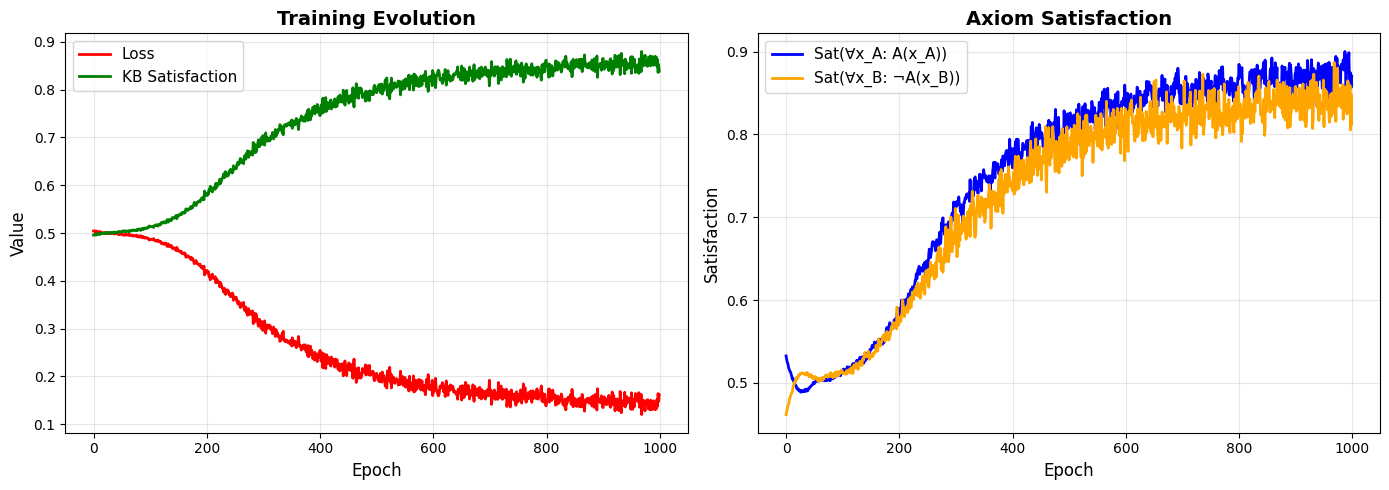

In [ ]:
print("\n📊 Step 5: Training history visualization...")
print("   Metrics:")
print("   - Loss: Model error (1 - Satisfaction)")
print("   - KB Satisfaction: Knowledge base satisfaction level")
print("   - Axiom Satisfaction: Individual axiom satisfaction\n")

classifier.plot_training_history()


🎯 Step 6: Visualizing learned decision boundary...
   Heatmap shows probability of classification as 'Cat'
   Black dashed line marks decision boundary (probability = 0.5)



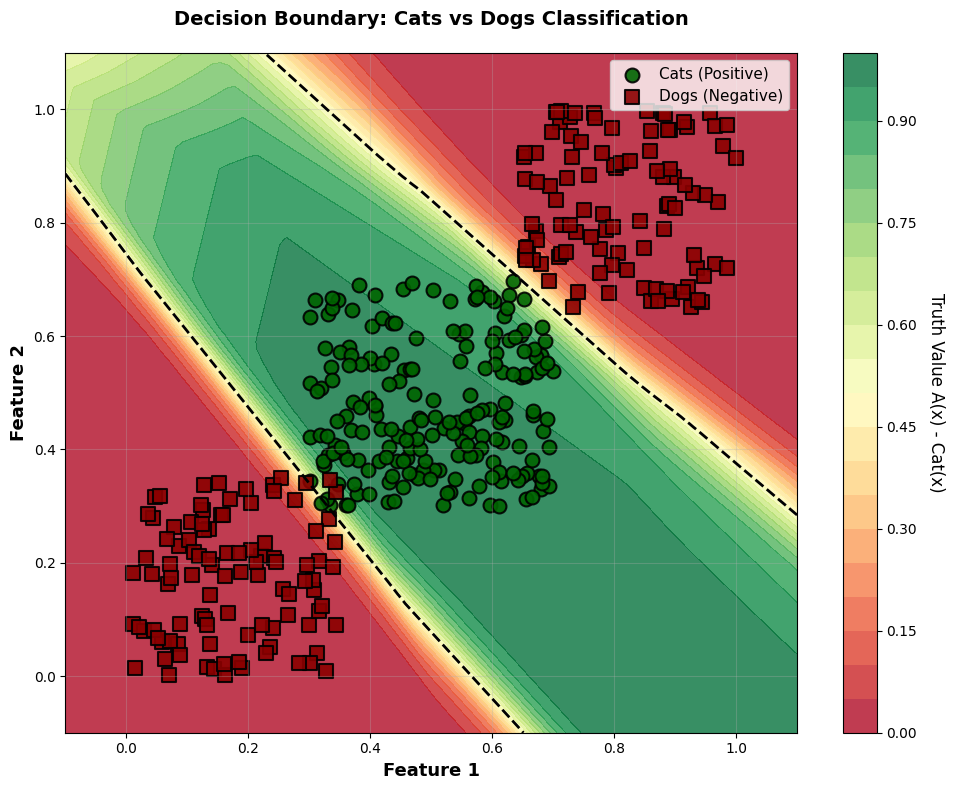

In [ ]:
print("\n🎯 Step 6: Visualizing learned decision boundary...")
print("   Heatmap shows probability of classification as 'Cat'")
print("   Black dashed line marks decision boundary (probability = 0.5)\n")

classifier.plot_decision_boundary(data_pos, data_neg, grid_size=PLOT_GRID_SIZE)

In [38]:
def test_predictions(classifier: BinaryClassifierLTN, test_points: torch.Tensor):
    """
    Test model predictions on sample points.

    Args:
        classifier: Trained LTN classifier
        test_points: Tensor of test points
    """
    print("\n🔮 Step 7: Testing predictions on sample points...")

    predictions = classifier.predict(test_points)

    print("\nPrediction Results:")
    print(f"{'Point':<20} {'Feature 1':<12} {'Feature 2':<12} {'P(Cat)':<12} {'Classification':<15}")
    print("-" * 75)

    for i, (point, pred) in enumerate(zip(test_points, predictions)):
        p_cat = pred.item()
        classification = "🐱 Cat" if p_cat > 0.5 else "🐕 Dog"
        print(f"Point {i+1:<14} {point[0].item():<12.3f} {point[1].item():<12.3f} {p_cat:<12.4f} {classification:<15}")

# Define test points
test_points = torch.tensor([
    [0.5, 0.5],  # Center (should be Cat)
    [0.1, 0.1],  # Lower left (should be Dog)
    [0.9, 0.9],  # Upper right (should be Dog)
    [0.6, 0.6],  # Near center (should be Cat)
    [0.2, 0.8]   # Intermediate point
], dtype=torch.float32)

test_predictions(classifier, test_points)


🔮 Step 7: Testing predictions on sample points...

Prediction Results:
Point                Feature 1    Feature 2    P(Cat)       Classification 
---------------------------------------------------------------------------
Point 1              0.500        0.500        0.9646       🐱 Cat          
Point 2              0.100        0.100        0.0002       🐕 Dog          
Point 3              0.900        0.900        0.0021       🐕 Dog          
Point 4              0.600        0.600        0.9299       🐱 Cat          
Point 5              0.200        0.800        0.9306       🐱 Cat          


In [ ]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

# Evaluate synthetic model
evaluate_model(classifier, data_pos, data_neg, "Synthetic Data")

print("\n✅ PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\n📝 What was demonstrated:")
print("   1. Logic Tensor Networks - Neuro-Symbolic Framework")
print("   2. Real-world data processing (ResNet18 → PCA)")
print("   3. Synthetic data generation and visualization")
print("   4. Training with fuzzy logic and logical axioms")
print("   5. Decision boundary learning and inference")
print("\n🎓 Key concepts:")
print("   • Fuzzy logic operators for differentiable reasoning")
print("   • Universal quantifiers (∀) for knowledge representation")
print("   • Logical axioms as training objectives")
print("   • Gradient descent on truth values [0,1]")
print("   • Neuro-symbolic integration")

print("\n" + "=" * 80)


FINAL SUMMARY

📈 Performance Summary - Synthetic Data

✅ Final Metrics:
   • Loss: 0.161119
   • KB Satisfaction: 0.838881
   • Axiom 1 Satisfaction: 0.870610
   • Axiom 2 Satisfaction: 0.812586

🎯 Training Accuracy:
   • Cats (should be > 0.5): 99.50%
   • Dogs (should be ≤ 0.5): 99.00%
   • Overall: 99.25%

🔮 Sample Predictions:
Type         Sample     P(Cat)       Classification 
--------------------------------------------------
Cat 1        1          0.6750       ✓ Cat          
Cat 2        2          0.9376       ✓ Cat          
Cat 3        3          0.9638       ✓ Cat          

Dog 1        1          0.0020       ✓ Dog          
Dog 2        2          0.0014       ✓ Dog          
Dog 3        3          0.0001       ✓ Dog          

✅ PROJECT COMPLETED SUCCESSFULLY!

📝 What was demonstrated:
   1. Logic Tensor Networks - Neuro-Symbolic Framework
   2. Real-world data processing (ResNet18 → PCA)
   3. Synthetic data generation and visualization
   4. Training with fuzzy l